In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import log
from scipy.special import erf, gammaincinv
from scipy.stats import t as student
from scipy.stats import chi2

%matplotlib inline

In [2]:
NORM_EX = 0 # normal mean (expected value)
NORM_SD = 3 # normal standard deviation
STUD_DF = 3 # student's degrees of freedom

'''
Generative function that creates a distribution
with a given size. Distribution type is random, but
you can affect it by setting the initial probability value.

Parameters:
    n - distribution size
    p - distribution's type probability

Returns:
    list of [distribution type, distribution array itself]
'''
def generate_distribution(n, p):
    if (np.random.uniform(0.0, 1.0, 1) > p):
        dist_type = "norm"
        dist = np.random.normal(NORM_EX, NORM_SD, n)
    else:
        dist_type = "stud"
        dist = student(STUD_DF).rvs(n)
    return [dist_type, dist]



In [3]:
'''
Laplace function.

Parameters:
    x - position(s) of x axis

Returns:
    value of laplace function at x
'''
def laplace_func(x):
    # compute a laplace value by using the error function
    return  erf(x / 2 ** 0.5) / 2

'''
Pearson's test function.

Parameters:
    distribution - array like object that has to be tested
    significance_level - alpha value between 0.0 and 1.0

Returns:
    map of Chi_square, Chi_critical and p-value
'''
def pearson_test(distribution, significance_level):
    # get the array size
    n = distribution.shape[0]
    # compute the mean value
    m = np.mean(distribution)
    # compute the standard deviation
    sd = np.sqrt(np.sum((distribution - m) ** 2) / (n - 1))
    # compute the distribution values bounds
    dist_interval = np.max(distribution) - np.min(distribution)
    # compute the segment size
    del_x = dist_interval / (1 + 3.3 * (log(n)))
    # write the segments borders into an array
    borders = np.arange(np.min(distribution), np.max(distribution) + del_x, del_x)
    # observed vlaues
    n_i = np.array([np.count_nonzero((distribution >= borders[i]) & (distribution < borders[i+1] )) \
        for i in range(borders.shape[0] - 1)])
    # z-score (standardised values)
    z = np.array([((i - m) / sd) for i in borders])
    # expected values
    p_i = np.array([ (laplace_func(z[i + 1]) - laplace_func(z[i])) for i in range(z.shape[0] - 1) ])
    # compute chi squared value
    chi_sqare = np.sum( ((n_i - n * p_i) ** 2) / (n * p_i) )
    # compute the chi-distribution's degrees of freedom
    # for normal distribution we have only 2 DoF
    k = n_i.shape[0] - 2 - 1
    # compute chi critical value, same as chi2.isf(significance_level, k)
    chi_critical = 2 * gammaincinv(k / 2, 1 - significance_level) 
    # calculate the p-value
    p_value = 1 - chi2.cdf(chi_sqare, k)
    return {"Chi_square" : chi_sqare, "Chi_critical" : chi_critical, "p-value" : p_value}

'''
Jarque-Bera's test function.

Parameters:
    distribution - array like object that has to be tested

Returns:
    map of Jarque_Bera and p-value
'''
def jarque_bera_test (distribution):
    # get the array size
    n = distribution.shape[0]
    # compute the mean value
    m = np.mean(distribution)
    # compute the standard deviation
    sd = np.sqrt(np.sum((distribution - m) ** 2) / (n - 1))
    # compute the skewness of the distribution
    skewness = np.sum((distribution - m) ** 3) / (n * sd ** 3)
    # compute the kurtosis of the distribution
    kurtosis = (np.sum((distribution - m) ** 4) / (n * sd ** 4)) - 3
    # compute the jarque-bera test score
    test_score = n/6 *(skewness**2 + kurtosis**2 / 4)
    # compute the p-value
    p_value = 1 - chi2.cdf(test_score, 2)
    return {"Jarque_Bera" : test_score, "p-value" : p_value}



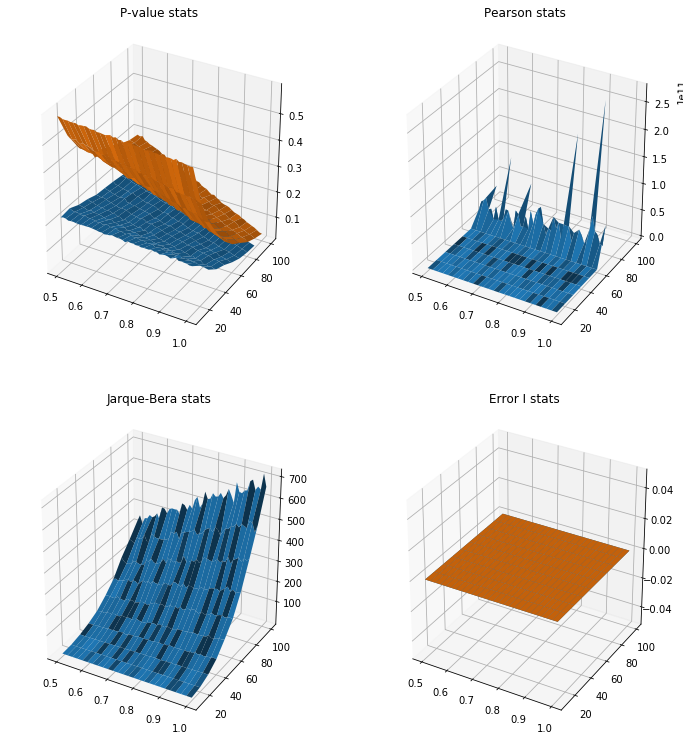

In [9]:
#arr = generate_distribution(100, 0)
#print(pearson_test(arr[1], 0.05))
#print(jarque_bera_test(arr[1]))

n = np.arange(10, 100 + 10, 10)             # list of selection sizes
p = np.arange(0.5, 1 + 0.01, 0.01)          # list of probabilities
presp = np.empty((n.shape[0], p.shape[0]))  # p-val result pearson's array
presj = np.empty((n.shape[0], p.shape[0]))  # p-val result jarque-bera's array
sresp = np.empty((n.shape[0], p.shape[0]))  # stats result pearson's array
sresj = np.empty((n.shape[0], p.shape[0]))  # stats result jarque-bera's array
X, Y = np.meshgrid(p, n)                    # meshgrid for plots

eresp = np.zeros((n.shape[0], p.shape[0]))  # error count pearson's array
eresj = np.zeros((n.shape[0], p.shape[0]))  # error count jarque-bera's array

count = 10000

# for all n and all p
for it_size in enumerate(n):
    for it_prob in enumerate(p):
        # nullify temporary arrays
        pr_pval = np.array([])
        jb_pval = np.array([])
        pr_stat = np.array([])
        jb_stat = np.array([])
        pr_lim = np.array([])
        # generate $(count) samples
        for it in range(count):
            arr = generate_distribution(it_size[1], it_prob[1])
            pr = pearson_test(arr[1], 0.05)
            jb = jarque_bera_test(arr[1])
            # bind resulting scores to the temporary arrays
            pr_pval = np.append(pr_pval, pr["p-value"])
            jb_pval = np.append(jb_pval, jb["p-value"])
            pr_stat = np.append(pr_stat, pr["Chi_square"])
            jb_stat = np.append(jb_stat, jb["Jarque_Bera"])
            # check if there are some type I errors
            if (arr[0] == 'normal' and pr_pval < 0.05):
                eresp += 1
            if (arr[0] == 'normal' and jb_pval < 0.05):
                eresj += 1
        # extract mean values of the temporary arrays
        presp[it_size[0], it_prob[0]] = np.mean(pr_pval)
        presj[it_size[0], it_prob[0]] = np.mean(jb_pval)
        sresp[it_size[0], it_prob[0]] = np.mean(pr_stat)
        sresj[it_size[0], it_prob[0]] = np.mean(jb_stat)

# build plots
fig = plt.figure(figsize=(12, 13))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(X, Y, presp)
ax1.plot_surface(X, Y, presj)
ax1.title.set_text('P-value stats')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_surface(X, Y, sresp)
ax2.title.set_text('Pearson stats')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot_surface(X, Y, sresj)
ax3.title.set_text('Jarque-Bera stats')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot_surface(X, Y, eresp)
ax4.plot_surface(X, Y, eresj)
ax4.title.set_text('Error I stats')

In [ ]:
'''
from numpy import e, inf
from scipy.special import gamma, gammainc, gammaincinv
from scipy.integrate import quad
from decimal import Decimal
from scipy.misc import derivative

def lower_incomplete_gamma_function(s: float = .0, x: float = .0):
    return (quad(lambda t: (t ** (s - 1)) * (e ** (-t)), 0, x)[0])


def gamma_function(z: float = .0):
    return (quad(lambda t: (t ** (z - 1)) * (e ** (-t)), 0, inf)[0])

def F(x, k):
    li = (lower_incomplete_gamma_function(k / 2, x / 2))
    g = (gamma_function(k / 2))
    print("gamma_incomplete", li, gammainc(k / 2, x / 2))
    print("gamma", g, gamma(k / 2))
    #print(1 - li / g)
    res = li / g
    #res = gammainc(k / 2, x / 2) / gamma(k / 2)
    #res = np.float128(5.8115079115215259e-12) / np.float128(287.88527781504445)
    return  res, li, g

def Finv(x, k):
    f = F(x, k)
    print(f[0])
    res = 2 * gammaincinv(k / 2, 1 - x) #(1 - gammaincinv(f, x / 2)) * gamma(k / 2)
    #res = 

    return res

print(Finv(0.05, 13))
'''